# Approximate Bayesian Computation: Likelihood-free rejection sampling

Florent Leclercq<br>
Imperial Centre for Inference and Cosmology, Imperial College London<br>
<a href="mailto:florent.leclercq@polytechnique.org">florent.leclercq@polytechnique.org</a>

In [1]:
import numpy as np
from scipy.stats import norm, invgamma, gaussian_kde
from matplotlib import pyplot as plt
from cycler import cycler
np.random.seed(123457)
%matplotlib inline
plt.rcParams.update({'lines.linewidth': 2})
colors=[plt.cm.Set2(i) for i in np.linspace(0, 1, 8)]
plt.rcParams.update({'axes.prop_cycle': cycler('color', colors)})

## Generate data

In this notebook we try to infer the unknown variance $\sigma^2$ of a zero-mean Gaussian distribution.

The data are $N_\mathrm{samp}$ samples from that distribution.

In [2]:
Nsamp=100

In [3]:
groundtruth=2.
likelihood=norm(loc=0.,scale=np.sqrt(groundtruth))

In [4]:
(dmin,dmax)=(-5,5)
data=likelihood.rvs(size=Nsamp)
lh_data=likelihood.pdf(data)
x_arr=np.arange(dmin,dmax,(dmax-dmin)/100.)
f_arr=likelihood.pdf(x_arr)

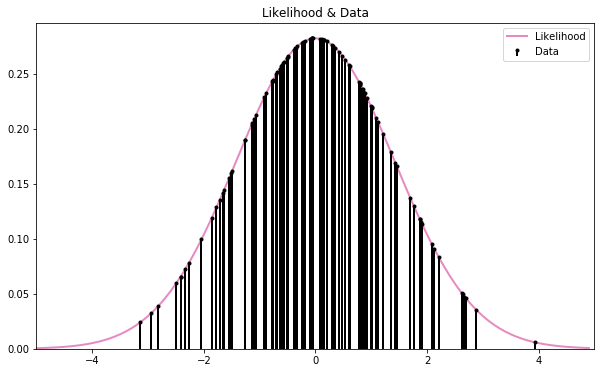

In [5]:
plt.figure(figsize=(10,6))
plt.xlim([dmin,dmax])
plt.plot(x_arr,f_arr,color=colors[3],label="Likelihood")
markerline, stemlines, baseline = plt.stem(data,lh_data,linefmt='-k',markerfmt='k.',label="Data")
baseline.set_visible(False)
plt.title("Likelihood & Data")
plt.legend()
plt.ylim(bottom=0.)
plt.show()

## Analytic solution

The Inverse Gamma distribution is conjugate prior for the unknown mean of a Gaussian process.
If the prior is $p(\sigma^2)=\mathrm{Inv\Gamma}(\alpha,\beta)$, then the posterior is
$p(\sigma^2|d)=\mathrm{Inv\Gamma}(\alpha',\beta')$ with
\begin{equation}
\alpha'=\alpha + \frac{N_\mathrm{samp}}{2} \quad \mathrm{and} \quad \beta'=\beta+\frac{1}{2} \sum_k d_k^2 .
\end{equation}

In [6]:
alpha=60
beta=130
prior=invgamma(alpha,loc=0,scale=beta)
alphaprime=alpha+Nsamp/2
betaprime=beta+1/2.*np.sum(data**2)
posterior=invgamma(alphaprime,loc=0,scale=betaprime)

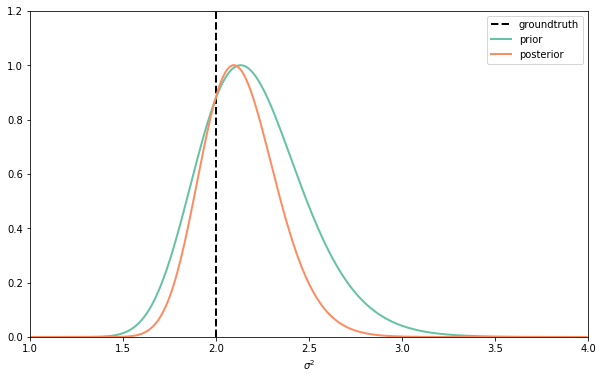

In [7]:
a=1
b=4
x=np.arange(a,b,0.01)
plt.figure(figsize=(10,6))
plt.xlim([a,b])
plt.xlabel("$\sigma^2$")
plt.ylim([0,1.2])
plt.plot([groundtruth,groundtruth],[0,1.2],linestyle='--',color='black',label="groundtruth")
plt.plot(x,prior.pdf(x)/prior.pdf(x).max(),label="prior")
plt.plot(x,posterior.pdf(x)/posterior.pdf(x).max(),label="posterior")
plt.legend()
plt.show()

## Likelihood-free rejection sampling

Given a parameter $\sigma^2$ drawn from the prior, the simulator generates $N_\mathrm{samp}$ samples
from a Gaussian with mean $0$ and variance $\sigma^2$.
The distance between a simulation $s$ and real data $d$ is
\begin{equation}
D(s,d)=\sqrt{\left[S(s)-S(k)\right]^2},
\end{equation}
where $S$ is a summary statistic of $s$ or $d$.

In [8]:
def simulator(var):
    return norm(loc=0.,scale=np.sqrt(var)).rvs(size=Nsamp)
def distance(sim_ss,data_ss):
    return np.sqrt(np.sum((sim_ss-data_ss)**2))

In [9]:
Ntries=10000

### Sufficient summary statistics

We first try a sufficient summary statistic: the estimated variance in this case

In [10]:
# sufficient summary statistics
def sufficient_summary_stat(data):
    return np.var(data)
data_ss=sufficient_summary_stat(data)

In [11]:
data_ss

2.049693396735127

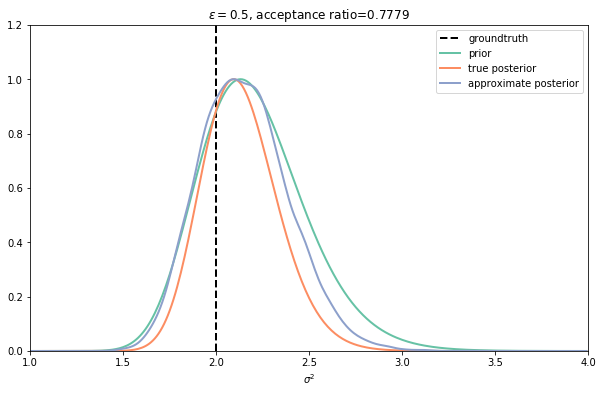

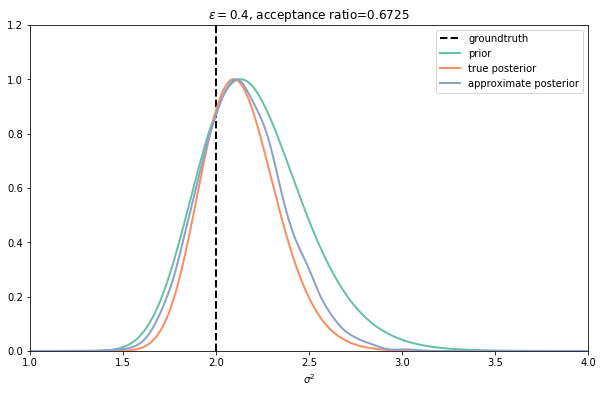

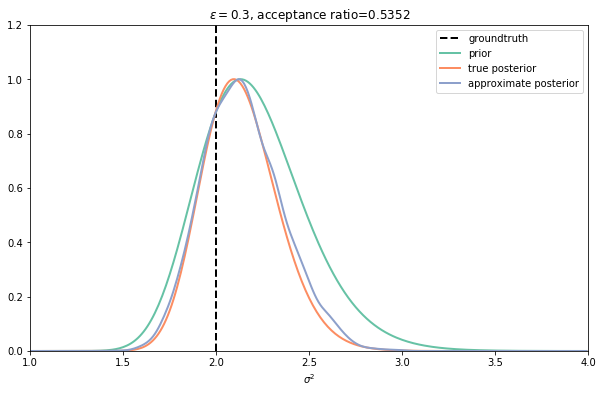

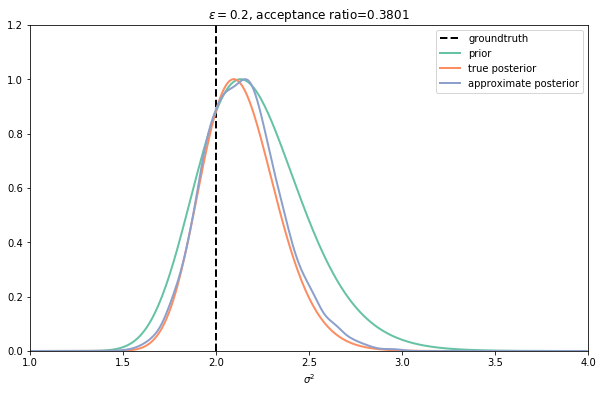

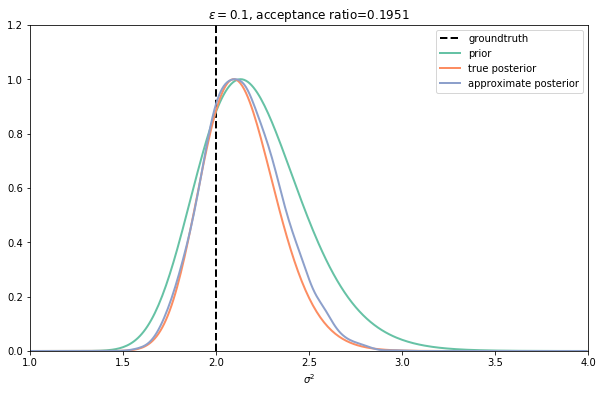

In [12]:
for epsilon in [0.5,0.4,0.3,0.2,0.1]:
    # likelihood-free rejection sampler
    # note that we never call the likelihood function!
    samples=[]
    for this_try in range(Ntries):
        this_var = prior.rvs(size=1)
        this_sim = simulator(this_var)
        this_ss = sufficient_summary_stat(this_sim)
        if(distance(this_ss,data_ss)<epsilon):
            samples.append(this_var)
    samples=np.array(samples).T[0]
    fraction_accepted=float(len(samples))/Ntries
    
    # kernel density estimation of the approximate posterior
    kernel=gaussian_kde(samples)
    
    # produce a plot
    plt.figure(figsize=(10,6))
    plt.xlim([a,b])
    plt.xlabel("$\sigma^2$")
    plt.ylim([0,1.2])
    plt.plot([groundtruth,groundtruth],[0,1.2],linestyle='--',color='black',label="groundtruth")
    plt.plot(x,prior.pdf(x)/prior.pdf(x).max(),label="prior")
    plt.plot(x,posterior.pdf(x)/posterior.pdf(x).max(),label="true posterior")
    plt.plot(x,kernel.evaluate(x)/kernel.evaluate(x).max(),label="approximate posterior")
    plt.title("$\\varepsilon="+str(epsilon)+"$, acceptance ratio="+str(fraction_accepted))
    plt.legend()
    plt.show()

### Insufficient summary statistics

We now try with an "insufficient" summary statistic: we throw away most of the data/simulation before estimating the variance

In [13]:
# insufficient summary statistics: throw away most of the information
def insufficient_summary_stat(data):
    return np.var(data[0:int(Nsamp/3.)])
data_ss=insufficient_summary_stat(data)

In [14]:
data_ss

2.0469947877411805

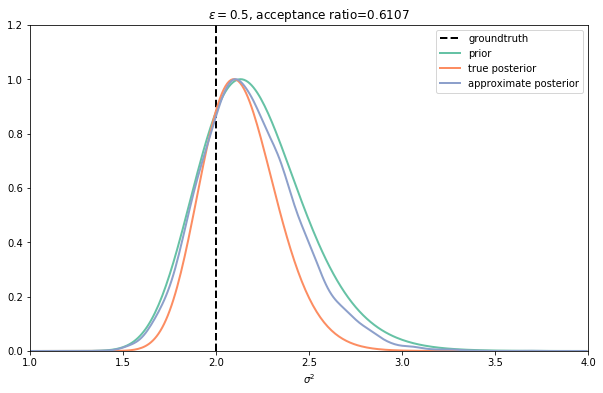

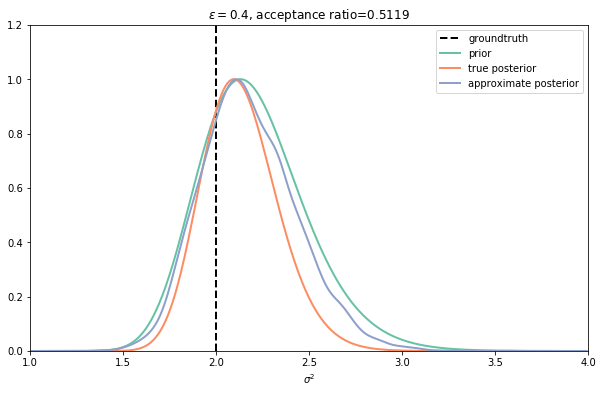

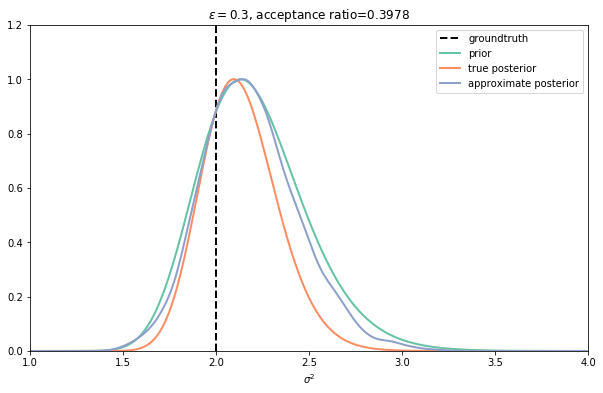

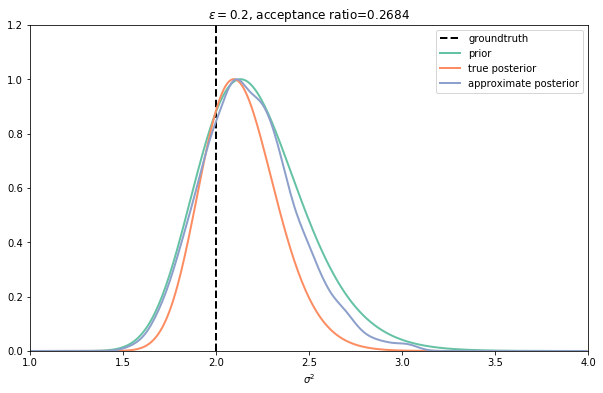

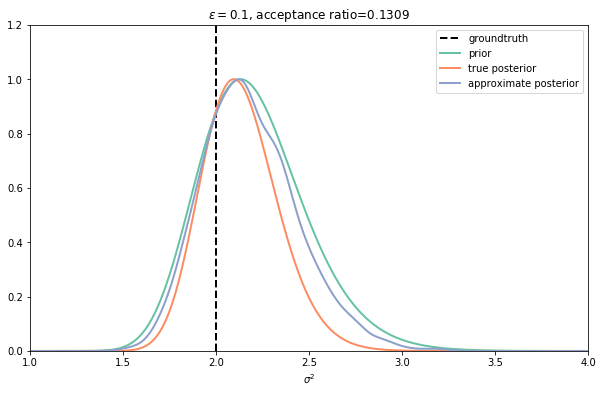

In [15]:
for epsilon in [0.5,0.4,0.3,0.2,0.1]:
    # likelihood-free rejection sampler
    # note that we never call the likelihood function!
    samples=[]
    for this_try in range(Ntries):
        this_var = prior.rvs(size=1)
        this_sim = simulator(this_var)
        this_ss = insufficient_summary_stat(this_sim)
        if(distance(this_ss,data_ss)<epsilon):
            samples.append(this_var)
    samples=np.array(samples).T[0]
    fraction_accepted=float(len(samples))/Ntries
    
    # kernel density estimation of the approximate posterior
    kernel=gaussian_kde(samples)
    
    # produce a plot
    plt.figure(figsize=(10,6))
    plt.xlim([a,b])
    plt.xlabel("$\sigma^2$")
    plt.ylim([0,1.2])
    plt.plot([groundtruth,groundtruth],[0,1.2],linestyle='--',color='black',label="groundtruth")
    plt.plot(x,prior.pdf(x)/prior.pdf(x).max(),label="prior")
    plt.plot(x,posterior.pdf(x)/posterior.pdf(x).max(),label="true posterior")
    plt.plot(x,kernel.evaluate(x)/kernel.evaluate(x).max(),label="approximate posterior")
    plt.title("$\\varepsilon="+str(epsilon)+"$, acceptance ratio="+str(fraction_accepted))
    plt.legend()
    plt.show()